In [1]:
#import libraries
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

 **INTRODUCTION**
 - Will be using NYC Taxi Fare <a href='https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'>Kaggle competition</a> dataset with about 55 million records. 
 - The data contains the pickup date & time, the latitude & longitude (GPS coordinates) of the pickup and dropoff locations, and the number of passengers
 - We will be predicting the **fare amount** of the trip

 To run the notebook on local system, the dataset is trimmed down to 120,000 records from April 11 to April 24, 2010. The records are randomly sorted.

# Data 

In [4]:
data = pd.read_csv('traindata/NYCTaxiFares.csv')
print(data.shape)

(120000, 8)


In [5]:
data.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [6]:
#will drop the fare class column
data.drop('fare_class', axis=1, inplace= True)
data['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

In [7]:
#check na values -- no na values
data.isna().sum().sort_values(ascending = False) / data.shape[0]

pickup_datetime      0.0
fare_amount          0.0
pickup_longitude     0.0
pickup_latitude      0.0
dropoff_longitude    0.0
dropoff_latitude     0.0
passenger_count      0.0
dtype: float64

# Feature Engineering 

In [8]:
'''
The data provides trips pickup & dropoff location.
This latitude & longitude information cannot be directly used 
while modeling. Thus we will calculate the distance of the trip 
using haversine distance & manhattan distance.
Further we will also calcualte bearing array to calculate the direction
of travel
'''

def haversine_distance(lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(long2-long1)
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    '''
    Calcualte dummy manhattan using the calcualted
    haversine distance
    '''
    a = haversine_distance(lat1, lng1, lat1, lng2)
    b = haversine_distance(lat1, lng1, lat2, lng1)
    return a + b


def bearing_array(lat1, lng1, lat2, lng2):
    '''
    Calculate the direction using the lat & long data
    '''
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


In [9]:
#haversine data
data['dist_haversine'] = haversine_distance(data['pickup_latitude'].values, 
                                             data['pickup_longitude'].values, data['dropoff_latitude'].values, 
                                             data['dropoff_longitude'].values)

#manhattan data
data['dist_dummy_manhattan'] = dummy_manhattan_distance(data['pickup_latitude'].values, 
                                                         data['pickup_longitude'].values, 
                                                         data['dropoff_latitude'].values, 
                                                         data['dropoff_longitude'].values)

#direction of travel
data['direction'] = bearing_array(data['pickup_latitude'].values, data['pickup_longitude'].values, 
                                   data['dropoff_latitude'].values, data['dropoff_longitude'].values)

In [10]:
#adding time features

data['Daylight_datetime'] = pd.to_datetime(data['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4) #due to daylight savings 
data['Hour'] = data['Daylight_datetime'].dt.hour  #time of pickup
data['AMorPM'] = np.where(data['Hour']<12,'am','pm')
data['Weekday'] = data['Daylight_datetime'].dt.strftime("%a")
data.head()

,pickup_datetime,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_haversine,dist_dummy_manhattan,direction,Daylight_datetime,Hour,AMorPM,Weekday
0,2010-04-19 08:17:56 UTC,6.5,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,3.002912,41.930412,2010-04-19 04:17:56,4,am,Mon
1,2010-04-17 15:43:53 UTC,6.9,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,1.730424,73.496003,2010-04-17 11:43:53,11,am,Sat
2,2010-04-17 11:23:26 UTC,10.1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,4.552117,59.639199,2010-04-17 07:23:26,7,am,Sat
3,2010-04-11 21:25:03 UTC,8.9,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2.539074,119.394631,2010-04-11 17:25:03,17,pm,Sun
4,2010-04-17 02:19:01 UTC,19.7,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,8.154644,82.094858,2010-04-16 22:19:01,22,pm,Fri


In [11]:
#creating clusters of regions based on lats & long data
from sklearn.cluster import MiniBatchKMeans

coords = np.vstack((data[['pickup_latitude', 'pickup_longitude']].values,
                    data[['dropoff_latitude', 'dropoff_longitude']].values))

#select number of clusters which minimizes the inertia
distortion = []
for k in range(10,100, 10) :
    
    k_means = MiniBatchKMeans(n_clusters= k, batch_size=10000)
    k_means.fit(coords)
    distortion.append(k_means.inertia_)
    

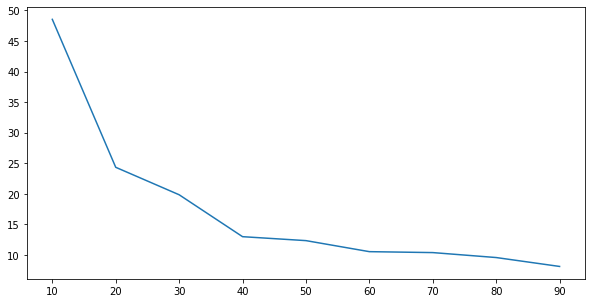

In [12]:
#elbow plot
plt.figure(figsize = (10,5))
plt.plot(range(10,100,10), distortion)
plt.show()

In [13]:
#using 20 clusters
k_means = MiniBatchKMeans(n_clusters= 30, batch_size=10000)
k_means.fit(coords)

data['pickup_cluster'] = k_means.predict(data[['pickup_latitude', 'pickup_longitude']])
data['dropoff_cluster'] = k_means.predict(data[['dropoff_latitude', 'dropoff_longitude']])

In [14]:
#separating categorical & numeric features
categorical_cols = ['Hour', 'AMorPM', 'Weekday', 'pickup_cluster', 'dropoff_cluster']
numerical_cols = ['passenger_count', 'dist_haversine', 'dist_dummy_manhattan', 'direction']
y_col = ['fare_amount']

In [15]:
#setting categorical cols
for col in categorical_cols :
    data[col] = data[col].astype('category')
    
#stacking categorical data
categorical_data = np.stack([data[col].cat.codes.values for col in categorical_cols], axis=1)
categorical_data = torch.tensor(categorical_data, dtype = torch.int64)

#creating categorical sizes & embedding size
cat_sizes = [len(data[col].cat.categories) for col in categorical_cols]
embedding_sizes = [(size, min(50, (size+1)//2)) for size in cat_sizes]
embedding_sizes

[(24, 12), (2, 1), (7, 4), (30, 15), (30, 15)]

In [16]:
#stacking numerical data
numerical_data = np.stack([data[col].values for col in numerical_cols], axis=1)
numerical_data = torch.tensor(numerical_data, dtype = torch.float)

In [17]:
#create label
y = torch.tensor(data[y_col].values, dtype = torch.float).reshape(-1,1)

# Modeling

In [18]:
class FarePredictionModel(nn.Module) :
    
    def __init__(self, embedding_size, num_of_numeric_feats, output_size, layers, p =0.5) :
        
        super().__init__()
        
        #creating embedding module
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in embedding_size])
        self.embeds_dropout = nn.Dropout(p)
        
        #batch normalization for numeric features
        self.batch_norm = nn.BatchNorm1d(num_of_numeric_feats)
        
        #define input layer
        num_of_embed_layer = sum([nf for ni,nf in embedding_size])
        input_size = num_of_embed_layer + num_of_numeric_feats
        
        #defining layers
        layer_list = []
        
        for i in layers :
            layer_list.append(nn.Linear(in_features= input_size, out_features= i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            input_size = i
            
        #appened outer layer
        layer_list.append(nn.Linear(layers[-1], output_size))
        
        #compile all the layers
        self.layers = nn.Sequential(*layer_list)
        
        
    def forward(self, X_Categorical, X_Numerical) :
        
        #embedding for categorical data
        embeddings_data = []
        for i,e in enumerate(self.embeds) :
            embeddings_data.append(e(X_Categorical[: ,i]))
        
            
        X = torch.cat(embeddings_data, 1)
        X = self.embeds_dropout(X)
        
        X_Numerical = self.batch_norm(X_Numerical)
        
        X = torch.cat([X, X_Numerical], axis=1)
        X = self.layers(X)
        
        return X
        


In [27]:
torch.manual_seed(42)
model = FarePredictionModel(embedding_sizes, numerical_data.shape[1], 1, [200,100], p=0.4)
model

FarePredictionModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
    (3): Embedding(30, 15)
    (4): Embedding(30, 15)
  )
  (embeds_dropout): Dropout(p=0.4, inplace=False)
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=51, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [23]:
criterion = nn.MSELoss()  # loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #optimizer

In [24]:
#split into train & test
batch_size = 60000
test_size = int(batch_size * .2)

cat_train = categorical_data[:batch_size-test_size]
cat_test = categorical_data[batch_size-test_size:batch_size]
con_train = numerical_data[:batch_size-test_size]
con_test = numerical_data[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [25]:
#train the model
import time
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

C:\Users\91954\Documents\pytorch_env\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([48000, 1])) that is different to the input size (torch.Size([48000, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1  loss: 12.55597878


KeyboardInterrupt: 

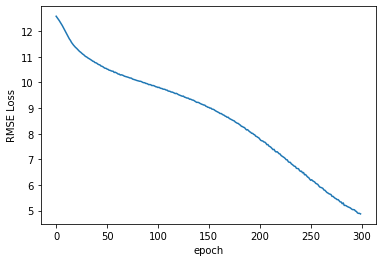

In [48]:
#plot the loss function
plt.plot(range(epochs), [x.detach().numpy() for x in losses])
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

In [49]:
# performance on test data
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 4.77853060


In [50]:
# save the pytorch model
torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')

In [51]:
#save the kmeans model
import pickle
pickle.dump(k_means, open('kMean_model.pkl', 'wb'))

# Making a Prediction 

In [54]:
#create new model
torch.manual_seed(42)
trained_model = FarePredictionModel(embedding_size= [(24, 12), (2, 1), (7, 4), (30, 15), (30, 15)],
                                  num_of_numeric_feats= 4,
                                  output_size= 1, layers= [200, 100, 50], p= 0.5 )

In [55]:
trained_model.load_state_dict(torch.load('TaxiFareRegrModel.pt'));
trained_model.eval()

TaxiDurationModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
    (3): Embedding(30, 15)
    (4): Embedding(30, 15)
  )
  (embeds_dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=51, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.5, inplace=Fals

In [60]:
def test_data(mdl): # pass in the name of the new model
    # INPUT NEW DATA
    plat = float(input('What is the pickup latitude?  '))
    plong = float(input('What is the pickup longitude? '))
    dlat = float(input('What is the dropoff latitude?  '))
    dlong = float(input('What is the dropoff longitude? '))
    psngr = int(input('How many passengers? '))
    dt = input('What is the pickup date and time?\nFormat as YYYY-MM-DD HH:MM:SS     ')
    
    # PREPROCESS THE DATA
    dfx_dict = {'pickup_latitude':plat,'pickup_longitude':plong,'dropoff_latitude':dlat,
         'dropoff_longitude':dlong,'passenger_count':psngr,'EDTdate':dt}
    dfx = pd.DataFrame(dfx_dict, index=[0])
    
    #haversine data
    dfx['dist_haversine'] = haversine_distance(dfx['pickup_latitude'].values, 
                                             dfx['pickup_longitude'].values, dfx['dropoff_latitude'].values, 
                                             dfx['dropoff_longitude'].values)

    #manhattan data
    dfx['dist_dummy_manhattan'] = dummy_manhattan_distance(dfx['pickup_latitude'].values, 
                                                             dfx['pickup_longitude'].values, 
                                                             dfx['dropoff_latitude'].values, 
                                                             dfx['dropoff_longitude'].values)

    #direction of travel
    dfx['direction'] = bearing_array(dfx['pickup_latitude'].values, dfx['pickup_longitude'].values, 
                                       dfx['dropoff_latitude'].values, dfx['dropoff_longitude'].values)
    
    #time features
    dfx['Daylight_datetime'] = pd.to_datetime(data['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4) 
    dfx['Hour'] = dfx['Daylight_datetime'].dt.hour  #time of pickup
    dfx['AMorPM'] = np.where(dfx['Hour']<12,'am','pm')
    dfx['Weekday'] = dfx['Daylight_datetime'].dt.strftime("%a")
    
    #pickup & dropoff clusters
    dfx['pickup_cluster'] = k_means.predict(dfx[['pickup_latitude', 'pickup_longitude']])
    dfx['dropoff_cluster'] = k_means.predict(dfx[['dropoff_latitude', 'dropoff_longitude']])
    
    
    # CREATE CAT AND CONT TENSORS
    categorical_cols = ['Hour', 'AMorPM', 'Weekday', 'pickup_cluster', 'dropoff_cluster']
    numerical_cols = ['passenger_count', 'dist_haversine', 'dist_dummy_manhattan', 'direction']
    
    #setting categorical cols
    for col in categorical_cols :
        dfx[col] = dfx[col].astype('category')

    #stacking categorical data
    xcats = np.stack([dfx[col].cat.codes.values for col in categorical_cols], axis=1)
    xcats = torch.tensor(xcats, dtype = torch.int64)

    xconts = np.stack([dfx[col].values for col in numerical_cols], 1)
    xconts = torch.tensor(xconts, dtype=torch.float)
    
    # PASS NEW DATA THROUGH THE MODEL WITHOUT PERFORMING A BACKPROP
    with torch.no_grad():
        z = trained_model(xcats, xconts)
    print(f'\nThe predicted fare amount is ${z.item():.2f}')

In [61]:
#prediction
z = test_data(trained_model)

What is the pickup latitude?  40.5
What is the pickup longitude? -73.5
What is the dropoff latitude?  40.52
What is the dropoff longitude? -73.92
How many passengers? 2
What is the pickup date and time?
Format as YYYY-MM-DD HH:MM:SS     2010-04-15 16:00:00

The predicted fare amount is $60.28
